## Working with UK census data

### Introduction
The census provides a rich set of demographic information that could be useful for various data science tasks, such as geomarketing, house price analysis etc. With the results of the 2021 census being published recently, this notebook demonstrates how to manipulate this data with FOSS python tools to build a dataset that can be used for downstream tasks.

For this demo, I will be focusing on output areas (OA) of London:
- download the boundaries for these OA
- download demographics datasets (population, household size, gender, education level)
- convert the irregular geometries of the OA into 100m by 100m cells
- calculate the avgerages for the demographics per bin
- convert the cell data into raster 

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
from tqdm import tqdm
import fiona
import rasterio as rio
from geocube.api.core import make_geocube

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Datasets

#### Population data 

for Census 2021 according to Output Area (https://www.ons.gov.uk/filters/b9532b29-299e-4a23-9fc8-b99d68e172b9/dimensions)

> Title: Population density
Description: This dataset provides Census 2021 estimates that classify usual residents in England and Wales by population density (number of usual residents per square kilometre). The estimates are as at Census Day, 21 March 2021.


> Output Areas (OAs) are the lowest level of geographical area for census statistics and were first created following the 2001 Census. Each OA is made up of between 40 and 250 households and a usually resident population of between 100 and 625 persons and may change after each census.


In [3]:
population_oa = pd.read_csv('data/uk-census-2021-oa.csv')
population_oa.head()

,Output Areas Code,Output Areas,Observation
0,E00000001,E00000001,26268.7
1,E00000003,E00000003,60952.4
2,E00000005,E00000005,12873.6
3,E00000007,E00000007,1959.2
4,E00000010,E00000010,71200.0


### Geographic manipulation-- OA boundaries to cells

To match the above OA codes with actual geography, we have to obtain the boundaries of each output area-- these can be found on [UK's goverment geoportal](https://geoportal.statistics.gov.uk/datasets/ons::output-areas-dec-2021-boundaries-generalised-clipped-ew-bgc/explore?location=52.593248%2C-2.489483%2C7.00)-- note that I am using the 'generalised' version instead of the full version.

In [4]:
boundaries = gpd.read_file('data/Output_Areas_(Dec_2021)_Boundaries_Generalised_Clipped_EW_(BGC)/Output_Areas_(Dec_2021)_Boundaries_Generalised_Clipped_EW_(BGC).shp')

In [5]:
boundaries.head()

,OBJECTID,OA21CD,GlobalID,Shape__Are,Shape__Len,geometry
0,1,E00000001,bc5eb21b-d42b-4715-a771-2c27575a08f0,6949.151482,421.166161,"POLYGON ((532303.492 181814.110, 532213.378 18..."
1,2,E00000003,a1a2b34f-320e-4bb8-acb4-7ca7ca16ef9c,4492.411072,307.714653,"POLYGON ((532213.378 181846.192, 532190.539 18..."
2,3,E00000005,9337da1a-fe0f-4210-9c95-ed2d20fd6287,8565.514214,385.204781,"POLYGON ((532180.131 181763.020, 532219.161 18..."
3,4,E00000007,b336e11f-af26-48a6-ac67-44f5b8b8840a,75994.829704,1408.607657,"POLYGON ((532201.292 181668.180, 532267.728 18..."
4,5,E00000010,ca8f9874-cdf5-4c1a-9d39-f74a410dae44,2102.876602,215.271975,"POLYGON ((532127.958 182133.192, 532089.264 18..."


In the boundaries geodataframe, the columns we'll need is that 'OA21CD', 'Shape_Are' and 'geometry columns': 'OA21CD' can join to the population dataset from above, Shape__Are gives the area of the OA in m^2 (note that this is different from the poulation measurement unit, which is in km^2). We can in fact cross check it against the geometry column

In [6]:
# check that the projection is indeed british national grid eastings and northings
print(f"geodata has projection of {boundaries.crs}")
# check that the geometry gives ~the same area as what shape_are gives to a 10m^2 tolerance
assert ((boundaries.area.astype(int)- boundaries.Shape__Are.astype(int)).abs() < 10).sum() == len(boundaries)

geodata has projection of epsg:27700


Since we are only interested in Greater London, we can filter out rows from the boundaries dataframe that are outside of the london bounding box.

We can get the bounding box of london using the OSM query https://nominatim.openstreetmap.org/search.php?city=london&country=uk&format=jsonv2 (the first entry is the correct one), giving a boundingbox of ymin, ymax, xmin, xmax of "51.2867602","51.6918741","-0.5103751","0.3340155"

In [7]:
ldn_bounding_box = Polygon.from_bounds( -0.5103751, 51.2867602,0.3340155, 51.691874 )
ldn_bounding_box = gpd.GeoSeries([ldn_bounding_box], crs='epsg:4326').to_crs(boundaries.crs)
ldn_bounding_box.geometry

0    POLYGON ((503976.311 155234.131, 503059.759 20...
dtype: geometry

Convert the geodataframe into a grid for downstream tasks-- Ordnance survey actually has a file of british grids at various resolutions prebuilt (https://github.com/OrdnanceSurvey/OS-British-National-Grids), -- the smallest is 1km by 1km, so we will construct our own 100m x 100m grid for london (We can do it for the whole uk, but we will have to iterate through the dataset as the number of cells will become very large)


---


**diversion**

This demos how to use the grid gpkg file from OS-- the gpkg is a vector file with multiple 'layers' the same way a raster file can have bands

In [8]:
# get the layer names
list(fiona.listlayers('data/os_bng_grids.gpkg'))

['100km_grid', '50km_grid', '20km_grid', '10km_grid', '5km_grid', '1km_grid']

In [9]:
layername = '1km_grid'
bsng_grid_1km = gpd.read_file('data/os_bng_grids.gpkg', layer=layername)
bsng_grid_1km.head()

,tile_name,geometry
0,HL0000,"POLYGON ((0.000 1200000.000, 1000.000 1200000...."
1,HL0001,"POLYGON ((0.000 1201000.000, 1000.000 1201000...."
2,HL0002,"POLYGON ((0.000 1202000.000, 1000.000 1202000...."
3,HL0003,"POLYGON ((0.000 1203000.000, 1000.000 1203000...."
4,HL0004,"POLYGON ((0.000 1204000.000, 1000.000 1204000...."


---

Back to our task, we filter out the OA that intersects the london bounding box:

In [10]:
gpd.GeoDataFrame(ldn_bounding_box.reset_index()).geometry

0    POLYGON ((503976.311 155234.131, 503059.759 20...
Name: 0, dtype: geometry

In [11]:
ldn_boundaries = boundaries[['OA21CD', 'geometry']].sjoin(gpd.GeoDataFrame(ldn_bounding_box.reset_index()), how='inner')[['OA21CD', 'geometry']]
ldn_boundaries.head()

,OA21CD,geometry
0,E00000001,"POLYGON ((532303.492 181814.110, 532213.378 18..."
1,E00000003,"POLYGON ((532213.378 181846.192, 532190.539 18..."
2,E00000005,"POLYGON ((532180.131 181763.020, 532219.161 18..."
3,E00000007,"POLYGON ((532201.292 181668.180, 532267.728 18..."
4,E00000010,"POLYGON ((532127.958 182133.192, 532089.264 18..."


In [12]:
ldn_bounding_box.geometry[0].bounds

(503059.75944664044, 155234.13110756868, 562854.9611320551, 201813.5769950911)

In [13]:
# create a 100m by 100m grid for london
cellsize=100
# British National Grid extent (0,0 700000,1300000)

xmin, ymin,  xmax, ymax = [100 * (x//100 )for x in ldn_bounding_box.geometry[0].bounds] 
matrix = np.mgrid[int(xmin):int(xmax + cellsize):cellsize, int(ymin):int(ymax+ cellsize):cellsize]

xcoor = matrix[0].flatten()
ycoor = matrix[1].flatten()

xcoor_max = xcoor +cellsize
ycoor_max = ycoor + cellsize

polygons = []
for x, y, xmax, ymax in tqdm(zip (xcoor, ycoor, xcoor_max, ycoor_max), total=len(ycoor)):
    polygons.append(Polygon.from_bounds(x, y, xmax, ymax))
grid = gpd.GeoDataFrame(data={'cellid': np.arange(len(polygons))},geometry=polygons, crs=boundaries.crs)

100%|████████████████████████████████| 279733/279733 [00:04<00:00, 60275.00it/s]


Join the grid to the OA polygons to get the demographics info per grid cell

In [14]:
print(grid.shape)
print(ldn_boundaries.shape)

ldn_demographics_grid = grid.sjoin(boundaries)

(279733, 2)
(30160, 2)


In [15]:
ldn_demographics_grid

,cellid,geometry,index_right,OBJECTID,OA21CD,GlobalID,Shape__Are,Shape__Len
0,0,"POLYGON ((503000.000 155200.000, 503000.000 15...",147286,147287,E00155442,5c96e7ec-ecb5-458b-b6e3-3f170061650d,312112.652298,2691.258154
1,1,"POLYGON ((503000.000 155300.000, 503000.000 15...",147286,147287,E00155442,5c96e7ec-ecb5-458b-b6e3-3f170061650d,312112.652298,2691.258154
2,2,"POLYGON ((503000.000 155400.000, 503000.000 15...",147286,147287,E00155442,5c96e7ec-ecb5-458b-b6e3-3f170061650d,312112.652298,2691.258154
467,467,"POLYGON ((503100.000 155200.000, 503100.000 15...",147286,147287,E00155442,5c96e7ec-ecb5-458b-b6e3-3f170061650d,312112.652298,2691.258154
468,468,"POLYGON ((503100.000 155300.000, 503100.000 15...",147286,147287,E00155442,5c96e7ec-ecb5-458b-b6e3-3f170061650d,312112.652298,2691.258154
...,...,...,...,...,...,...,...,...
279671,279671,"POLYGON ((562800.000 195700.000, 562800.000 19...",103204,103205,E00108990,53fb368c-3684-4be0-b859-93b09ea9fdd4,84283.686378,1503.476417
279672,279672,"POLYGON ((562800.000 195800.000, 562800.000 19...",103204,103205,E00108990,53fb368c-3684-4be0-b859-93b09ea9fdd4,84283.686378,1503.476417
279673,279673,"POLYGON ((562800.000 195900.000, 562800.000 19...",103204,103205,E00108990,53fb368c-3684-4be0-b859-93b09ea9fdd4,84283.686378,1503.476417
279674,279674,"POLYGON ((562800.000 196000.000, 562800.000 19...",103204,103205,E00108990,53fb368c-3684-4be0-b859-93b09ea9fdd4,84283.686378,1503.476417


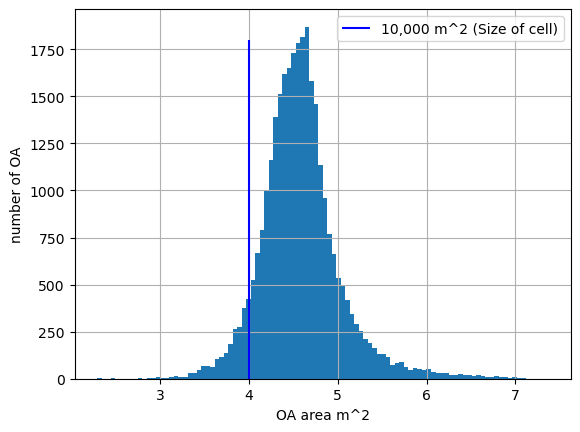

In [16]:
# as we can see, the OA size span is quite large --luckily most OA are larger than a grid cell. 
ax =ldn_demographics_grid.drop_duplicates(subset='OA21CD').Shape__Are.apply(np.log10).hist(bins = 100)
ax.set_xlabel('OA area m^2')
ax.set_ylabel('number of OA')
ax.vlines(4,0,1800, colors='b', label='10,000 m^2 (Size of cell)')
ax.legend()

There are clearly duplicates-- e.g. when a grid cell span more than 1 OA, and where 1OA span more than 1cell-- this is more likely for the OA to span mutliple cells than the other way round. Base on this assumption, we assign each cell to one OA by dropping duplicadtes

In [17]:
ldn_demographics_grid = ldn_demographics_grid.drop_duplicates(subset='cellid')

In [18]:
# drop all the unneed cols
ldn_demographics_grid = ldn_demographics_grid[['cellid', 'OA21CD', 'geometry']]

Finally, let's populate these grid cells with demographic data
- [household size by OA](https://www.ons.gov.uk/datasets/TS017/editions/2021/versions/2/filter-outputs/1799bd24-15d0-43ca-81d4-bccb7434f0d4#get-data)
- [education](https://www.ons.gov.uk/datasets/TS067/editions/2021/versions/1/filter-outputs/55e2442d-5a41-4ca2-872f-030d52af39d7#get-data)
- [population density]((https://www.ons.gov.uk/filters/b9532b29-299e-4a23-9fc8-b99d68e172b9/dimensions)
- [sex](https://www.ons.gov.uk/datasets/TS008/editions/2021/versions/3/filter-outputs/4f979d87-7e23-4e29-83ed-db14647e92ba#get-data)

We have discussed the population data above, let's now tidy up the other datasets

#### household size

In [19]:
houshold = pd.read_csv('data/household_size_output_area_census2021.csv')
houshold.head()

,Output Areas Code,Output Areas,Household size (9 categories) Code,Household size (9 categories),Observation
0,E00000001,E00000001,0,0 people in household,0
1,E00000001,E00000001,1,1 person in household,34
2,E00000001,E00000001,2,2 people in household,44
3,E00000001,E00000001,3,3 people in household,10
4,E00000001,E00000001,4,4 people in household,6


We can use the 'code' as a proxy for household size

In [20]:
houshold[['Household size (9 categories)', 'Household size (9 categories) Code']].drop_duplicates()

,Household size (9 categories),Household size (9 categories) Code
0,0 people in household,0
1,1 person in household,1
2,2 people in household,2
3,3 people in household,3
4,4 people in household,4
5,5 people in household,5
6,6 people in household,6
7,7 people in household,7
8,8 or more people in household,8


In [21]:
mean_household_size = houshold[['Output Areas Code', 'Household size (9 categories) Code','Observation']]
mean_household_size['counts'] = mean_household_size['Household size (9 categories) Code'] * mean_household_size['Observation']
mean_household_size = mean_household_size.groupby('Output Areas Code')['counts'].sum()
mean_household_size_totals = houshold[['Output Areas Code', 'Household size (9 categories) Code','Observation']].groupby('Output Areas Code')['Observation'].sum()

/tmp/ipykernel_16911/2961719914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_household_size['counts'] = mean_household_size['Household size (9 categories) Code'] * mean_household_size['Observation']


In [22]:
mean_household_size.reset_index()

,Output Areas Code,counts
0,E00000001,176
1,E00000003,256
2,E00000005,112
3,E00000007,145
4,E00000010,173
...,...,...
188875,W00010693,78
188876,W00010694,404
188877,W00010695,189
188878,W00010696,237


In [23]:
mean_household_size = mean_household_size.reset_index().merge(mean_household_size_totals.reset_index(), on='Output Areas Code')
mean_household_size['avg_household_size'] = mean_household_size['counts'] /  mean_household_size['Observation']
mean_household_size.head()

,Output Areas Code,counts,Observation,avg_household_size
0,E00000001,176,94,1.872340
1,E00000003,256,109,2.348624
2,E00000005,112,63,1.777778
3,E00000007,145,87,1.666667
4,E00000010,173,125,1.384000


#### gender

In [24]:
gender = pd.read_csv('data/uk-census-2021-sex-oa.csv')
gender.head()

,Output Areas Code,Output Areas,Sex (2 categories) Code,Sex (2 categories),Observation
0,E00000001,E00000001,1,Female,75
1,E00000001,E00000001,2,Male,101
2,E00000003,E00000003,1,Female,123
3,E00000003,E00000003,2,Male,135
4,E00000005,E00000005,1,Female,52


In [25]:
females = gender[gender['Sex (2 categories)'] == 'Female']
gender_total = gender.groupby(['Output Areas Code'])['Observation'].sum().reset_index()
percent_female = females[['Output Areas', 'Observation']].merge(gender_total, left_on='Output Areas', right_on='Output Areas Code')
percent_female['pct'] = percent_female['Observation_x'] / percent_female['Observation_y']
percent_female.head()

,Output Areas,Observation_x,Output Areas Code,Observation_y,pct
0,E00000001,75,E00000001,176,0.426136
1,E00000003,123,E00000003,258,0.476744
2,E00000005,52,E00000005,112,0.464286
3,E00000007,67,E00000007,144,0.465278
4,E00000010,71,E00000010,178,0.398876


#### education

In [26]:
education = pd.read_csv('data/uk-census-2021-education-oa.csv')
education.head()

,Output Areas Code,Output Areas,Highest level of qualification (8 categories) Code,Highest level of qualification (8 categories),Observation
0,E00000001,E00000001,-8,Does not apply,15
1,E00000001,E00000001,0,No qualifications,4
2,E00000001,E00000001,1,Level 1 and entry level qualifications: 1 to 4...,7
3,E00000001,E00000001,2,Level 2 qualifications: 5 or more GCSEs (A* to...,10
4,E00000001,E00000001,3,Apprenticeship,1


In [27]:
education[['Highest level of qualification (8 categories) Code','Highest level of qualification (8 categories)'	]].drop_duplicates()

,Highest level of qualification (8 categories) Code,Highest level of qualification (8 categories)
0,-8,Does not apply
1,0,No qualifications
2,1,Level 1 and entry level qualifications: 1 to 4...
3,2,Level 2 qualifications: 5 or more GCSEs (A* to...
4,3,Apprenticeship
5,4,Level 3 qualifications: 2 or more A levels or ...
6,5,"Level 4 qualifications and above: degree (BA, ..."
7,6,Other: vocational or work-related qualificatio...


here make the simplifying assumption that we ignore the 'does not apply category', and the categories code go up in more advanced education

In [28]:
mean_education_level = education[['Output Areas Code', 'Highest level of qualification (8 categories) Code','Observation']]
mean_education_level['counts'] = mean_education_level['Highest level of qualification (8 categories) Code'].clip(lower=0) * mean_education_level['Observation']
mean_education_level = mean_education_level.groupby('Output Areas Code')['counts'].sum()
mean_education_level_totals = education[['Output Areas Code', 'Highest level of qualification (8 categories) Code','Observation']].groupby('Output Areas Code')['Observation'].sum()
mean_education_level = mean_education_level.reset_index().merge(mean_education_level_totals.reset_index(), on='Output Areas Code')
mean_education_level['avg_education_level'] = mean_education_level['counts'] /  mean_education_level['Observation']
mean_education_level.head()

/tmp/ipykernel_16911/566605148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_education_level['counts'] = mean_education_level['Highest level of qualification (8 categories) Code'].clip(lower=0) * mean_education_level['Observation']


,Output Areas Code,counts,Observation,avg_education_level
0,E00000001,714,175,4.080000
1,E00000003,1022,257,3.976654
2,E00000005,485,113,4.292035
3,E00000007,640,144,4.444444
4,E00000010,656,179,3.664804


### Joining information together

Finally, we can join the demograhics data onto the geomtry to get gridded demographics data

In [29]:
# add education level info
ldn_demographics_grid_processed = ldn_demographics_grid.merge(mean_education_level[[
    'Output Areas Code', 'avg_education_level']], left_on='OA21CD', right_on='Output Areas Code').drop(columns='Output Areas Code')
# add % female
ldn_demographics_grid_processed = ldn_demographics_grid_processed.merge(percent_female[[
    'Output Areas Code', 'pct']], left_on='OA21CD', right_on='Output Areas Code').drop(columns='Output Areas Code').rename(columns={'pct': 'pct_females'})
# add mean household size
ldn_demographics_grid_processed = ldn_demographics_grid_processed.merge(mean_household_size[[
    'Output Areas Code', 'avg_household_size']], left_on='OA21CD', right_on='Output Areas Code').drop(columns='Output Areas Code')


ldn_demographics_grid_processed = ldn_demographics_grid_processed.merge(population_oa[[
    'Output Areas Code', 'Observation']], left_on='OA21CD', right_on='Output Areas Code').drop(columns='Output Areas Code').rename(
    columns={'Observation': 'pop_density'})
ldn_demographics_grid_processed['popoulation'] = ldn_demographics_grid_processed['pop_density'] * (100 * 100)/(1000 * 1000)
ldn_demographics_grid_processed.head()

,cellid,OA21CD,geometry,avg_education_level,pct_females,avg_household_size,pop_density,popoulation
0,0,E00155442,"POLYGON ((503000.000 155200.000, 503000.000 15...",2.839161,0.522807,2.567568,915.5,9.155
1,1,E00155442,"POLYGON ((503000.000 155300.000, 503000.000 15...",2.839161,0.522807,2.567568,915.5,9.155
2,2,E00155442,"POLYGON ((503000.000 155400.000, 503000.000 15...",2.839161,0.522807,2.567568,915.5,9.155
3,467,E00155442,"POLYGON ((503100.000 155200.000, 503100.000 15...",2.839161,0.522807,2.567568,915.5,9.155
4,468,E00155442,"POLYGON ((503100.000 155300.000, 503100.000 15...",2.839161,0.522807,2.567568,915.5,9.155


In [30]:
ldn_demographics_grid_processed.to_file('data/ldn_demographics_grid_processed.shp')

/tmp/ipykernel_16911/324827064.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ldn_demographics_grid_processed.to_file('data/ldn_demographics_grid_processed.shp')


### Rasterizing geodataframe

Certain tools work better with raster data, and since we have converted our data from a irregular geometry into cells, we can go all the way and convert the vector data into raster, using [geocube](https://corteva.github.io/geocube). 

**Capping/binning population values**

The population values have a fairly long tail-- let's cap this so it is easier to plot and handle

In [31]:
# printing out some stats -- we can see 95% cells have < 150 people

ldn_demographics_grid_processed['popoulation'].quantile([0.2, 0.4, 0.6, 0.8]),ldn_demographics_grid_processed['popoulation'].quantile([0.05]),  ldn_demographics_grid_processed['popoulation'].quantile([0.95]), ldn_demographics_grid_processed['popoulation'].min(), ldn_demographics_grid_processed['popoulation'].max()

(0.2     1.024
 0.4     4.157
 0.6    21.138
 0.8    62.500
 Name: popoulation, dtype: float64,
 0.05    0.321
 Name: popoulation, dtype: float64,
 0.95    130.5817
 Name: popoulation, dtype: float64,
 0.156,
 2393.333)

In [32]:
ldn_demographics_grid_processed['popoulation'] = ldn_demographics_grid_processed['popoulation'].clip(lower=0, upper=150)

In [33]:
ldn_demographics_grid_processed['popoulation'].max()

150.0

Now we convert the vector to raster (the resolution is what we are using for each of our cells-- 100m )

In [34]:
ldn_demographics_raster = make_geocube(
    vector_data=ldn_demographics_grid_processed,
    measurements=["popoulation", "avg_education_level", "pct_females"],
    resolution=(-100, 100),
)


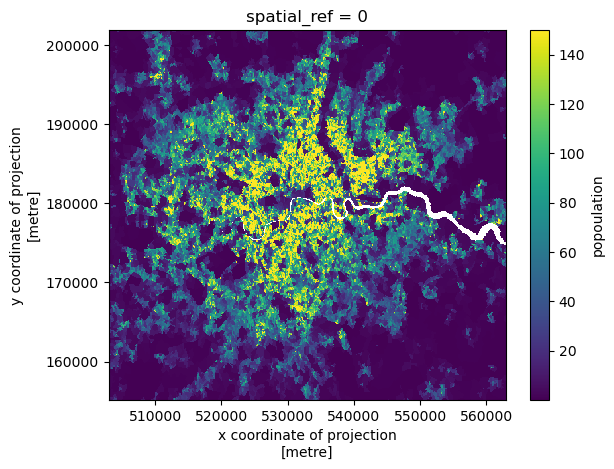

In [35]:
ldn_demographics_raster['popoulation'].plot()

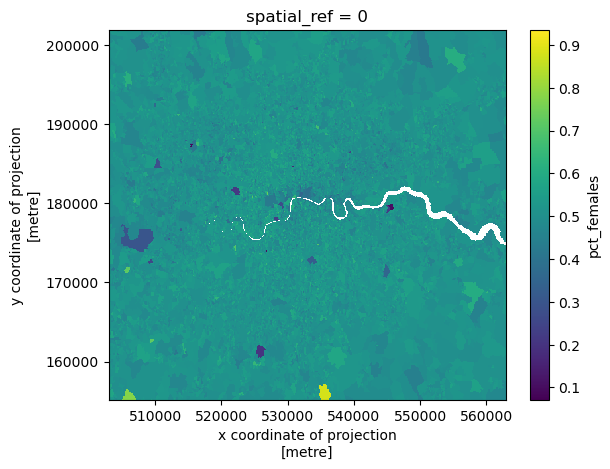

In [36]:
ldn_demographics_raster['pct_females'].plot()

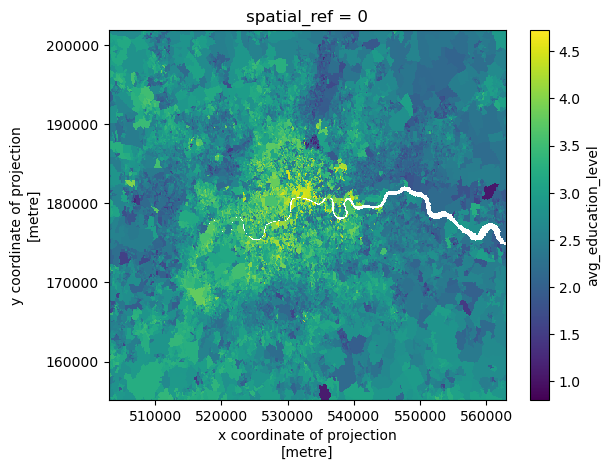

In [37]:
ldn_demographics_raster['avg_education_level'].plot()

In [38]:
# save our raster data
ldn_demographics_raster.rio.to_raster("data/ldn_demographics_raster.tiff")

### Rasterization with rasterio

Rasterio also has an option (using [`rasterio.features.rasterize`](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.rasterize)to rasterize our vector data--note that it can only operate on 1 attribute at a time,rather than a set of attributes all at once